In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score

import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('housing.csv')
df.drop(['Address'], axis = 1, inplace = True)
df

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05
...,...,...,...,...,...,...
4995,60567.944140,7.830362,6.137356,3.46,22837.361035,1.060194e+06
4996,78491.275435,6.999135,6.576763,4.02,25616.115489,1.482618e+06
4997,63390.686886,7.250591,4.805081,2.13,33266.145490,1.030730e+06
4998,68001.331235,5.534388,7.130144,5.44,42625.620156,1.198657e+06


In [3]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [4]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=42)

# HistGBM

In [8]:
clf = HistGradientBoostingRegressor()

In [9]:
clf.fit(Xtrain, ytrain)

HistGradientBoostingRegressor()

In [10]:
r2_score(ytest, clf.predict(Xtest))

0.8946874652566936

In [26]:
params = {'learning_rate':[0.05, 0.1, 0.2, 0.3, 0.5],
         'max_leaf_nodes':range(2,35),
         'max_depth':range(2,30), 
         'min_samples_leaf':range(2,30),
         'l2_regularization': [0.1, 0.2, 0.3, 0.5, 0.7], 
         'max_bins' : [50, 100, 150, 255, 300]}

In [27]:
tune = RandomizedSearchCV(clf, params, n_iter=10, n_jobs=-1, cv = KFold(5), verbose = 8)

In [28]:
tune.fit(Xtrain, ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=HistGradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'l2_regularization': [0.1, 0.2, 0.3,
                                                              0.5, 0.7],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.5],
                                        'max_bins': [50, 100, 150, 255, 300],
                                        'max_depth': range(2, 30),
                                        'max_leaf_nodes': range(2, 35),
                                        'min_samples_leaf': range(2, 30)},
                   verbose=8)

In [29]:
tune.best_estimator_

HistGradientBoostingRegressor(l2_regularization=0.3, learning_rate=0.2,
                              max_bins=100, max_depth=20, max_leaf_nodes=5,
                              min_samples_leaf=25)

In [30]:
new_clf = HistGradientBoostingRegressor(l2_regularization=0.3, learning_rate=0.2,
                              max_bins=100, max_depth=20, max_leaf_nodes=5,
                              min_samples_leaf=25)

In [31]:
new_clf.fit(Xtrain, ytrain)

HistGradientBoostingRegressor(l2_regularization=0.3, learning_rate=0.2,
                              max_bins=100, max_depth=20, max_leaf_nodes=5,
                              min_samples_leaf=25)

In [32]:
r2_score(ytest, new_clf.predict(Xtest))

0.8978816941356116

In [34]:
scores = cross_val_score(new_clf, Xtrain, ytrain, scoring='r2', cv = KFold(5))

In [35]:
scores.mean()

0.8989659571589982

In [36]:
scores

array([0.90230359, 0.8878647 , 0.89681425, 0.90288681, 0.90496043])

# Light GBM

In [23]:
import lightgbm
lgbm = lightgbm.LGBMRegressor()

In [13]:
lgbm.fit(Xtrain, ytrain)

LGBMRegressor()

In [16]:
#r2_score(ytest, lgbm.predict(Xtest))
scores = cross_val_score(lgbm, Xtrain, ytrain, scoring='r2', cv = KFold(5))
print(scores, "\n",scores.mean())

[0.9034474  0.8848175  0.8914185  0.90054739 0.89963265] 
 0.8959726867028703


### Hyp tuning - not done properly but this is how it is done

In [44]:
params = {
         'num_leaves':range(5,200),
         'max_depth':range(2,20),
         'max_bin':range(50,301,50),
         'min_data_in_bin':range(5,20),
          'learning_rate': [0.05,0.1,0.2,0.3,0.5,0.7],
          'n_estimators': [50,100,150,200,250,300,350]
         }

In [45]:
tune = RandomizedSearchCV(lgbm, params, n_iter=10, n_jobs=-1, cv = KFold(10))

In [46]:
tune.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.5, 0.7],
                                        'max_bin': range(50, 301, 50),
                                        'max_depth': range(2, 20),
                                        'min_data_in_bin': range(5, 20),
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350],
                                        'num_leaves': range(5, 200)})

In [47]:
tune.best_estimator_

LGBMRegressor(max_bin=200, max_depth=2, min_data_in_bin=7, n_estimators=250,
              num_leaves=64)

In [48]:
new_lgbm = lightgbm.LGBMRegressor(max_bin=200, max_depth=2, min_data_in_bin=7, n_estimators=250,
              num_leaves=64)

In [49]:
 new_lgbm.fit(Xtrain, ytrain)

LGBMRegressor(max_bin=200, max_depth=2, min_data_in_bin=7, n_estimators=250,
              num_leaves=64)

In [50]:
scores = cross_val_score(new_lgbm, Xtrain, ytrain, scoring='r2', cv = KFold(5))
print(scores, "\n",scores.mean())

[0.90789596 0.89258685 0.90645352 0.90976483 0.90922251] 
 0.9051847335444438


In [72]:
sort = new_lgbm.feature_importances_.argsort()

Text(0.5, 0, 'Feature Importance')

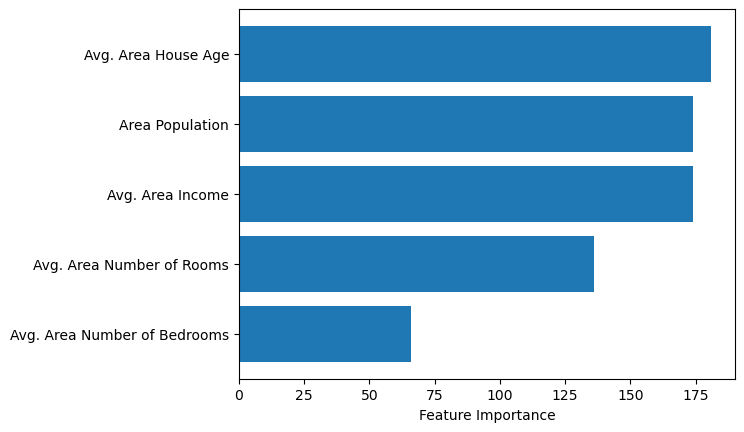

In [73]:
plt.barh(df.columns[sort], new_lgbm.feature_importances_[sort])
plt.xlabel("Feature Importance")